In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, scipy
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as pyplot
# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri
import rpy2.robjects.numpy2ri
#import numpy2ri

pandas2ri.activate()
anndata2ri.activate()
rpy2.robjects.numpy2ri.activate()

%load_ext rpy2.ipython

# d50_d70 all cells

## umaps/Featureplots

In [54]:
adata_d50_d70 = sc.read('Data/adata_d50_d70.h5ad')


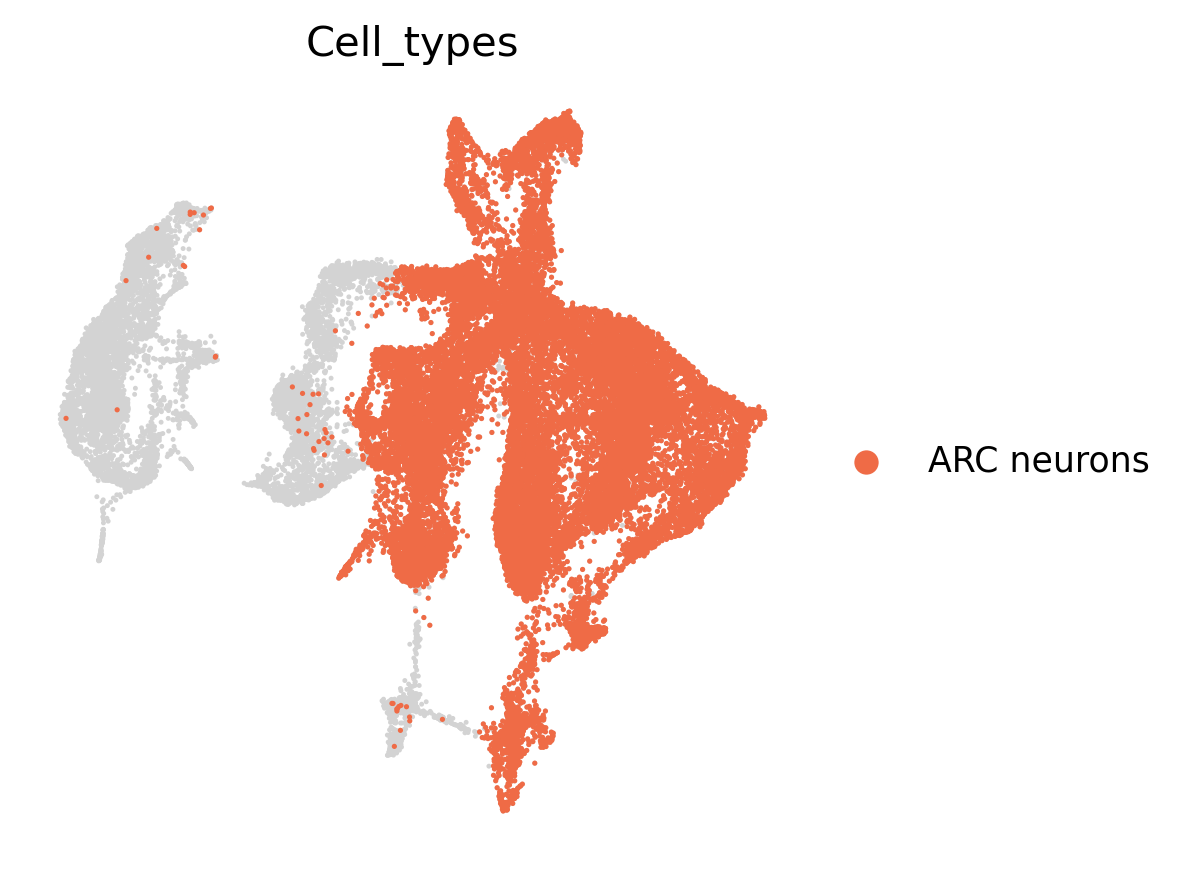

In [9]:
with plt.rc_context({ "figure.dpi": 250, "figure.figsize": (4,4)}):
    ax = sc.pl.umap(
    adata_d50_d70,
    frameon=False,
    show=False,size=8
    )
    sc.pl.umap(
        adata_d50_d70[adata_d50_d70.obs.Cell_types.isin(['ARC neurons'])],
        color=['Cell_types'],
        frameon=False,
        #title="Query predictions",
        ax=ax,palette=['#EF6B46'],
        #alpha=0.7,
        size=9, save='_arc_neurons.pdf'
    )

In [54]:
for color in ['S100B']:
    with plt.rc_context({ "figure.dpi": 300, "figure.figsize": (4,4) }):
        sc.pl.umap(adata_d50_d70, color=color,cmap='jet', ncols=2, use_raw=False, frameon=False, colorbar_loc=None,size=12, save=f'd50_d70_{color}.pdf', show=False,layer='log_transformed')
        #sc.pl.umap(adata_d50_d70, color=color, ncols=2, use_raw=False, cmap='jet', frameon=False, colorbar_loc=None,size=12)

## DE analysis

In [ ]:
adata_d50_d70 = sc.read('Data/adata_d50_d70.h5ad')


In [4]:
%%R -i adata_d50_d70

Csparse_validate = "CsparseMatrix_validate"
library(Seurat)
library(edgeR)

seur <- as.Seurat(adata_d50_d70, counts = "counts", data = NULL)

#seur <- readRDS("Data/d50_d70_neurons_seurat.rds")
seur <- RenameAssays(seur, originalexp="RNA")

y <- Seurat2PB(seur, sample = "diff_batch_2", cluster = "Cell_types")
keep.samples <- y$samples$lib.size > 5e4
y <- y[, keep.samples]
keep.genes <- filterByExpr(y, group=y$samples$cluster)
y <- y[keep.genes, , keep=FALSE]
y <- normLibSizes(y)

cluster <- as.factor(y$samples$cluster)
#plotMDS(y, pch=16, col=c(2:16)[cluster], main="MDS")
#legend("bottomright", legend=paste0("cluster",levels(cluster)), pch=16, col=2:16, cex=0.8)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Attaching SeuratObject

Attaching package: ‘Seurat’

The following object is masked from ‘package:SummarizedExperiment’:

    Assays

Loading required package: limma

Attaching package: ‘limma’

The following object is masked from ‘package:BiocGenerics’:

    plotMA


Attaching package: ‘edgeR’

The following object is masked from ‘package:SingleCellExperiment’:

    cpm

Renaming default assay from originalexp to RNA
In addition: Warning message:
Cannot add objects with duplicate keys (offending key: originalexp_) setting key to original value 'rna_' 


In [5]:
%%R
batch <- factor(y$samples$sample)
design <- model.matrix(~ cluster + batch)
colnames(design) <- gsub("batch", "", colnames(design))
colnames(design)[1] <- "Int"
head(design)

  Int clusterImmature ARC neurons clusterTanycytes clusterTelencephalic neurons
1   1                           0                0                            0
2   1                           1                0                            0
3   1                           0                1                            0
4   1                           0                0                            1
5   1                           0                0                            0
6   1                           1                0                            0
  -2 -3
1  0  0
2  0  0
3  0  0
4  0  0
5  1  0
6  1  0


In [6]:

%%R
y <- estimateDisp(y, design, robust=TRUE)
fit <- glmQLFit(y, design, robust=TRUE)

In [7]:
%%R
ncls <- nlevels(cluster)
contr <- rbind( matrix(1/(1-ncls), ncls, ncls), matrix(0, ncol(design)-ncls, ncls) )
diag(contr) <- 1
contr[1,] <- 0
rownames(contr) <- colnames(design)
colnames(contr) <- paste0("cluster", levels(cluster))
contr

                             clusterARC neurons clusterImmature ARC neurons
Int                                   0.0000000                   0.0000000
clusterImmature ARC neurons          -0.3333333                   1.0000000
clusterTanycytes                     -0.3333333                  -0.3333333
clusterTelencephalic neurons         -0.3333333                  -0.3333333
-2                                    0.0000000                   0.0000000
-3                                    0.0000000                   0.0000000
                             clusterTanycytes clusterTelencephalic neurons
Int                                 0.0000000                    0.0000000
clusterImmature ARC neurons        -0.3333333                   -0.3333333
clusterTanycytes                    1.0000000                   -0.3333333
clusterTelencephalic neurons       -0.3333333                    1.0000000
-2                                  0.0000000                    0.0000000
-3                

In [8]:
%%R
qlf <- list()
for(i in 1:ncls){
 qlf[[i]] <- glmQLFTest(fit, contrast=contr[,i])
 qlf[[i]]$comparison <- paste0("cluster", levels(cluster)[i], "_vs_others")
}

In [9]:
%%R
top <- 200
topMarkers <- list()

de_df = data.frame(matrix( 
  vector(), 0, 7, dimnames=list(c(), c("gene","logFC","logCPM","F","PValue","FDR",'comparison'))), 
                stringsAsFactors=F)

for(i in 1:ncls) {
    #print(head(qlf[[i]])$comparison)
    ord <- order(qlf[[i]]$table$PValue, decreasing=FALSE)
    up <- qlf[[i]]$table$logFC[ord] > 0
    topMarkers[[i]] <- rownames(y)[ord[up][1:top]]
    #genes = 
    df = as.data.frame(topTags(qlf[[i]], n='all'))
    df =df[rownames(df) %in% rownames(y)[ord[up][1:top]], ]  
    df$comparison <- head(qlf[[i]])$comparison
    de_df = rbind(de_df, df)
}
print(dim(de_df))

write.csv(de_df, "d50_70_arc_de_list.csv")
#topMarkers <- unique(unlist(topMarkers))
#topMarkers

[1] 800   8


In [10]:
de_genes = pd.read_csv('d50_70_arc_de_list.csv',index_col=0)
de_genes['cluster'] = de_genes['comparison'].str.extract(r'cluster(.*?)_vs_others')
de_genes = de_genes[['gene','logFC','logCPM','F','PValue','FDR','comparison','cluster']]
de_genes.to_excel("d50_70_arc_de_list.xlsx")  
de_genes

gene     logFC    logCPM           F        PValue  \
AL133372.2  AL133372.2  4.144996  2.476498  519.739725  3.687779e-11   
BRINP1          BRINP1  1.863033  6.096955  510.940189  4.072128e-11   
ANK1              ANK1  2.255511  5.011244  510.498933  4.092603e-11   
IL18R1          IL18R1  3.244346  2.604998  456.833418  7.792388e-11   
KCNC2            KCNC2  2.284284  6.566094  416.926902  1.322181e-10   
...                ...       ...       ...         ...           ...   
TNRC6C          TNRC6C  0.678321  7.948560   85.912697  8.851702e-07   
PPP4R4          PPP4R4  1.053357  5.101396   85.670177  8.984324e-07   
SEL1L3          SEL1L3  1.324991  4.296000   85.422691  9.122062e-07   
MAST2            MAST2  0.701597  7.493123   85.326871  9.176053e-07   
PCDH19          PCDH19  1.761002  3.710606   85.295271  9.193940e-07   

                     FDR                              comparison  \
AL133372.2  3.129033e-07            clusterARC neurons_vs_others   
BRINP1      3.129033e-07            clusterARC neurons_vs_others   
ANK1        3.129033e-07            clusterARC neurons_vs_others   
IL18R1      3.129033e-07            clusterARC neurons_vs_others   
KCNC2       3.646199e-07            clusterARC neurons_vs_others   
...                  ...                                     ...   
TNRC6C      9.192416e-05  clusterTelencephalic neurons_vs_others   
PPP4R4      9.290100e-05  clusterTelencephalic neurons_vs_others   
SEL1L3      9.346397e-05  clusterTelencephalic neurons_vs_others   
MAST2       9.346397e-05  clusterTelencephalic neurons_vs_others   
PCDH19      9.346397e-05  clusterTelencephalic neurons_vs_others   

                          cluster  
AL133372.2            ARC neurons  
BRINP1                ARC neurons  
ANK1                  ARC neurons  
IL18R1                ARC neurons  
KCNC2                 ARC neurons  
...                           ...  
TNRC6C      Telencephalic neurons  
PPP4R4      Telencephalic neurons  
SEL1L3      Telencephalic neurons  
MAST2       Telencephalic neurons  
PCDH19      Telencephalic neurons  

[800 rows x 8 columns]

In [11]:
de_dict = {}
for cluster in list(de_genes.cluster.unique()):
    de_dict[str(cluster)] = list(de_genes.groupby('cluster').get_group(cluster).gene)[0:15]
#de_dict
de_genes['cluster'].value_counts()

cluster
ARC neurons              200
Immature ARC neurons     200
Tanycytes                200
Telencephalic neurons    200
Name: count, dtype: int64

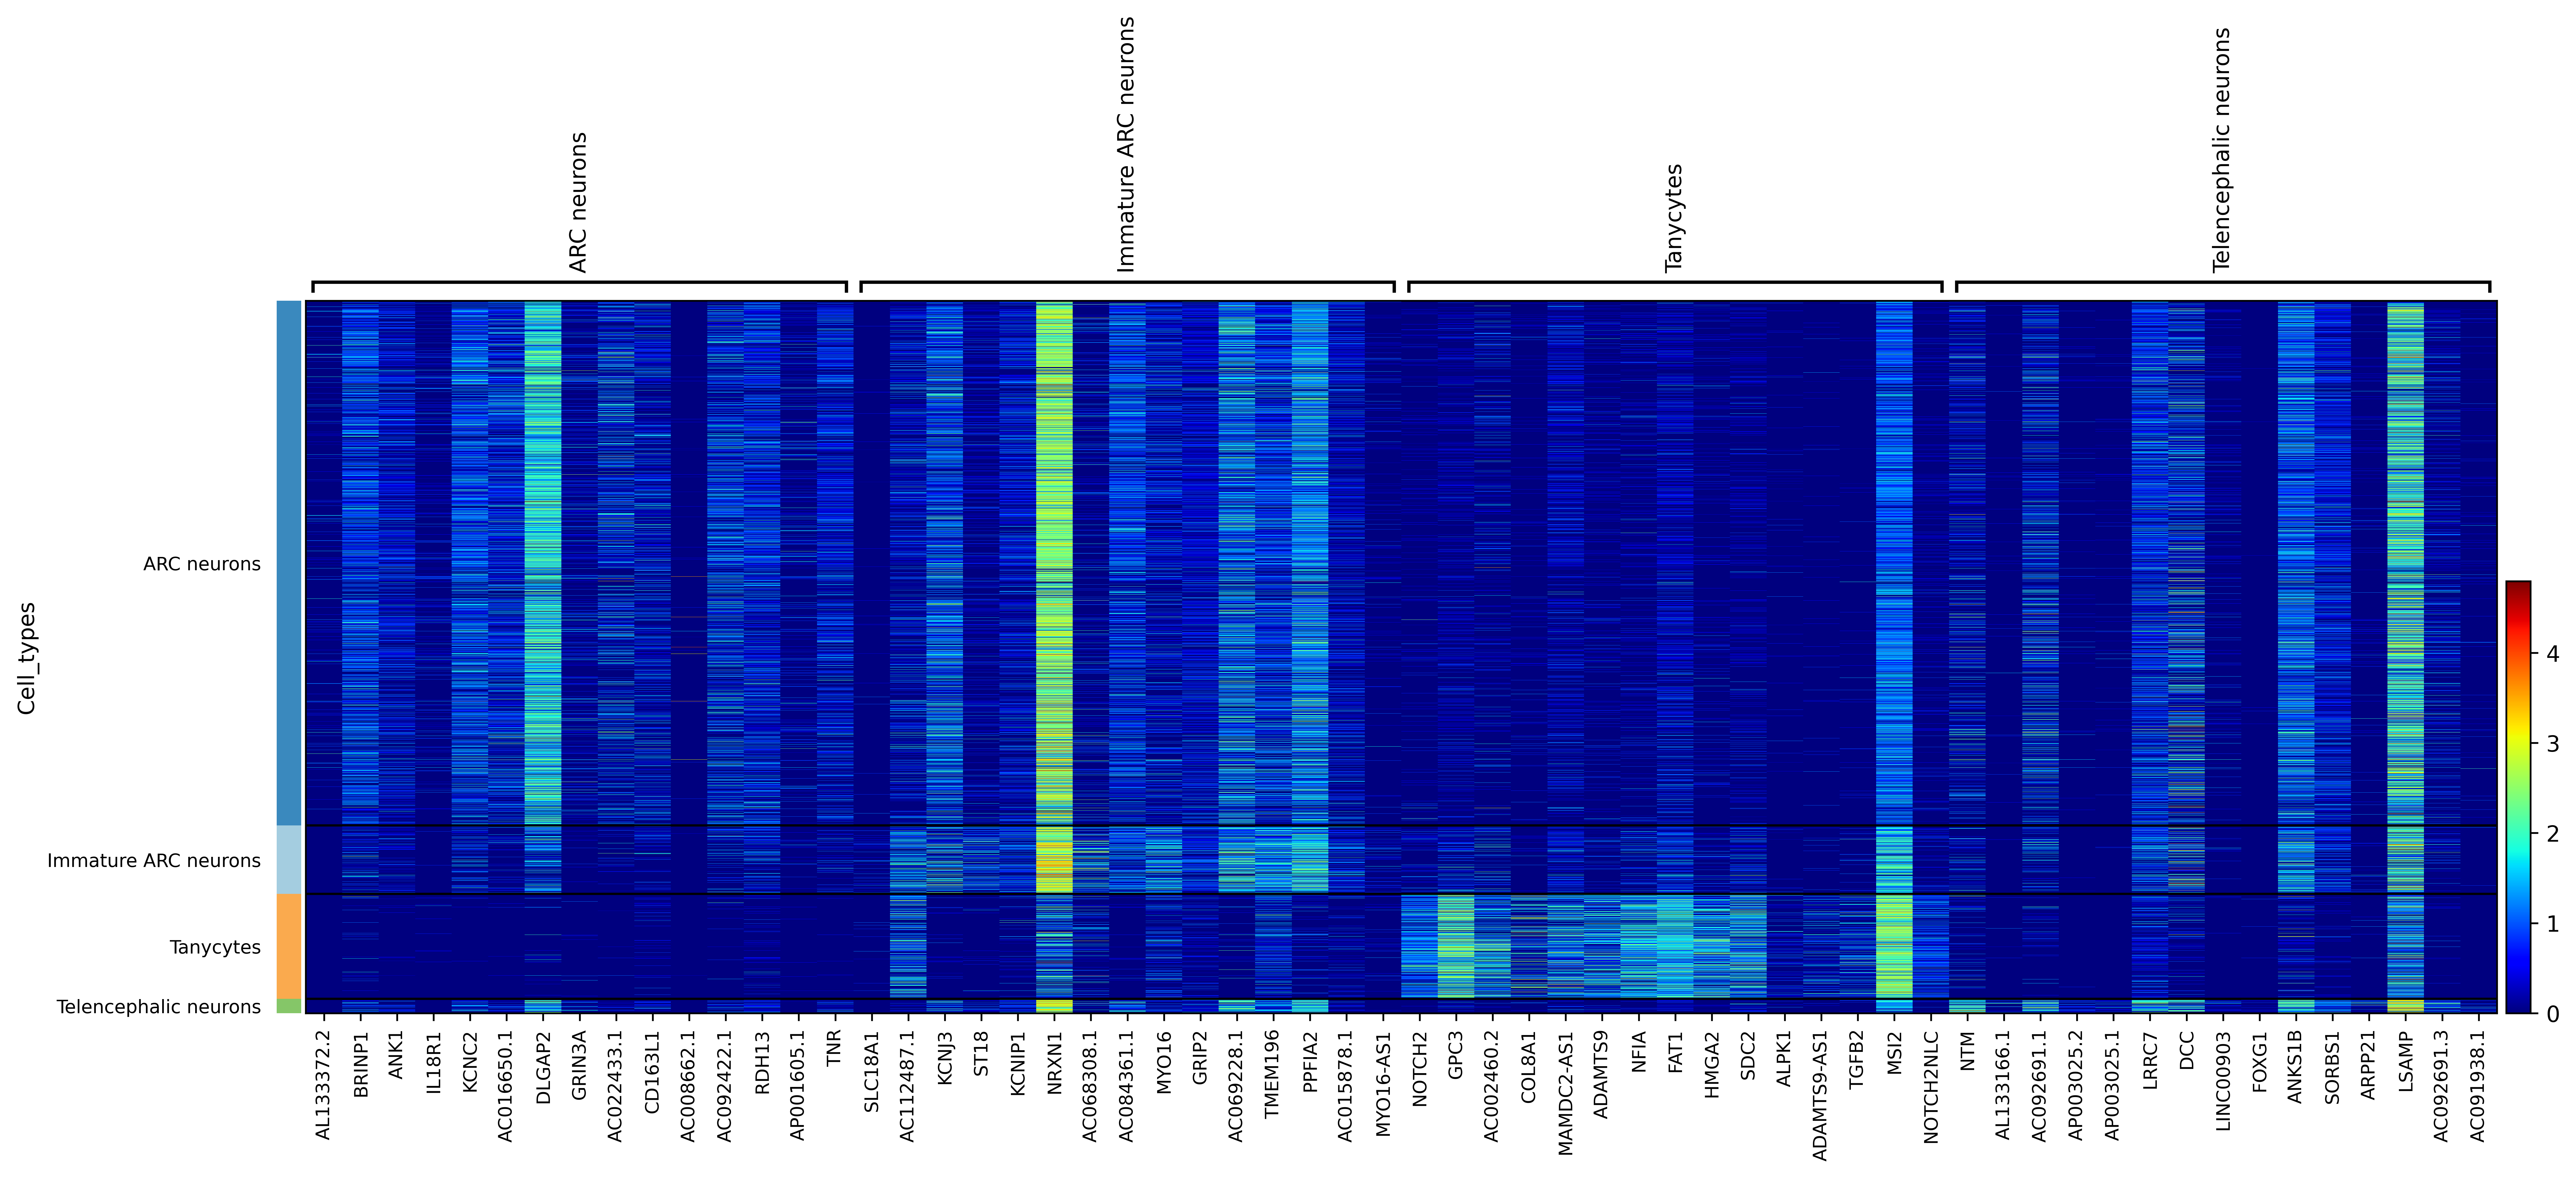

In [12]:
with plt.rc_context({ "figure.dpi": 600, "figure.figsize": (100,10)}):
    sc.pl.heatmap(adata_d50_d70,de_dict, groupby='Cell_types', show_gene_labels=True, layer='log_transformed',cmap='jet')

# Neurons d50_d70


In [2]:
adata_neurons = sc.read('Data/adata_d50_d70_neurons.h5ad')

In [3]:
for color in ['LEPR','GAD2','SLC17A6','SLC17A7']:
    with plt.rc_context({ "figure.dpi": 300, "figure.figsize": (4,4) }):
        sc.pl.umap(adata_neurons, color=color,cmap='jet', ncols=2, use_raw=False, frameon=False, colorbar_loc=None,size=12, save=f'd50_d70_neurons_{color}.pdf', show=False,layer='log_transformed')

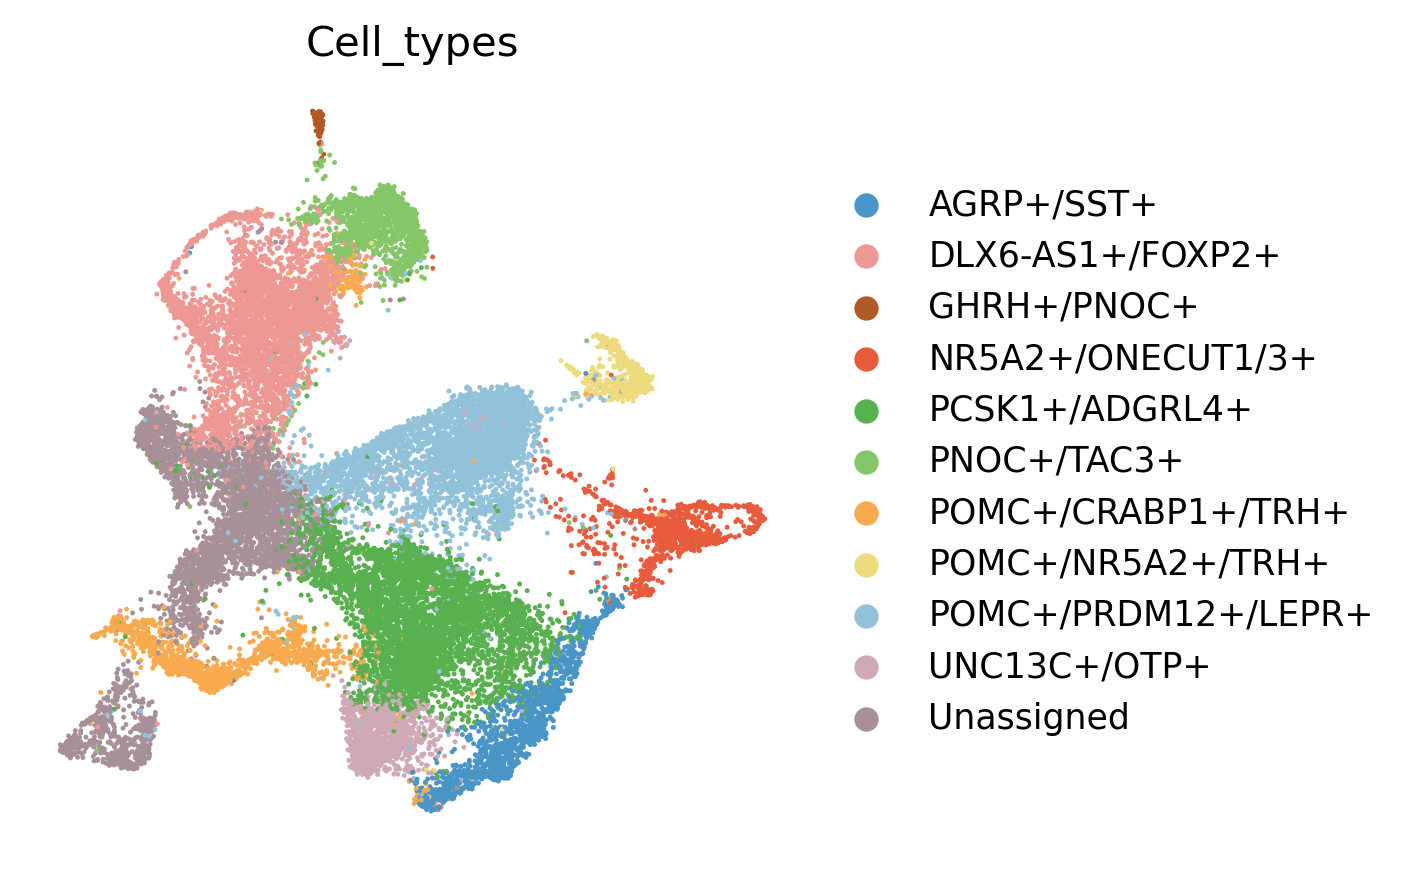

In [28]:
with plt.rc_context({ "figure.dpi": 250, "figure.figsize": (4,4)}):
    sc.pl.umap(adata_neurons, color=['Cell_types'],frameon=False, use_raw=False, size=8,
               ncols=2,cmap='jet',wspace=0.4)

## Dotplot

In [30]:
adata_neurons = sc.read('Data/adata_d50_d70_neurons.h5ad')

In [32]:
%%R -i adata_neurons
library(Seurat)
sobj <- as.Seurat(adata_neurons, counts = NULL, data = "log_transformed")


In [38]:
%%R
library(ggplot2)
genes = c('SST','GAD2','OTP','AGRP','DLX6-AS1','FOXP2','GHRH','PNOC','NR5A2','ONECUT1','ADGRL4','PCSK1','TAC3','CRABP1','TRH','PRDM12','ISL1','TBX3','POMC','LEPR','ANXA2','UNC13C')
Idents(object = sobj) <- "Cell_types"
Idents(object = sobj) <- factor(sobj@active.ident,c('Unassigned', 'UNC13C+/OTP+', 'POMC+/PRDM12+/LEPR+', 'POMC+/NR5A2+/TRH+', 'POMC+/CRABP1+/TRH+', 'PNOC+/TAC3+', 'PCSK1+/ADGRL4+', 'NR5A2+/ONECUT1/3+', 'GHRH+/PNOC+', 'DLX6-AS1+/FOXP2+', 'AGRP+/SST+'))

#dotplot=DotPlot(object = sobj, features = genes, scale=T,dot.min='0.1') + theme(axis.text.x = element_text(angle = 45, hjust=1))
dotplot=DotPlot(object = sobj, features = genes,  scale=T,dot.min = 0.08,  cols = c("#FFFFFF", "#386fa4")) + theme(axis.text.x = element_text(size=10, face="italic", angle = 45, hjust=1), axis.text.y = element_text(size=10), legend.title = element_text(size=8)) + ylab("")
#dotplot=DotPlot(object = sobj, features = genes,  cols = c("#FFFFFF", "#386fa4")) + theme(axis.text.x = element_text(size=10, face="italic", angle = 45, hjust=1), axis.text.y = element_text(size=10), legend.title = element_text(size=8)) + ylab("")

ggsave("figures/d50_d70_neurons_dotplot.pdf", plot= dotplot, width=8.2, height=5, dpi=300, bg='white')

In addition: Warning message:
Removed 69 rows containing missing values or values outside the scale range
(`geom_point()`). 


## Cluster proportions

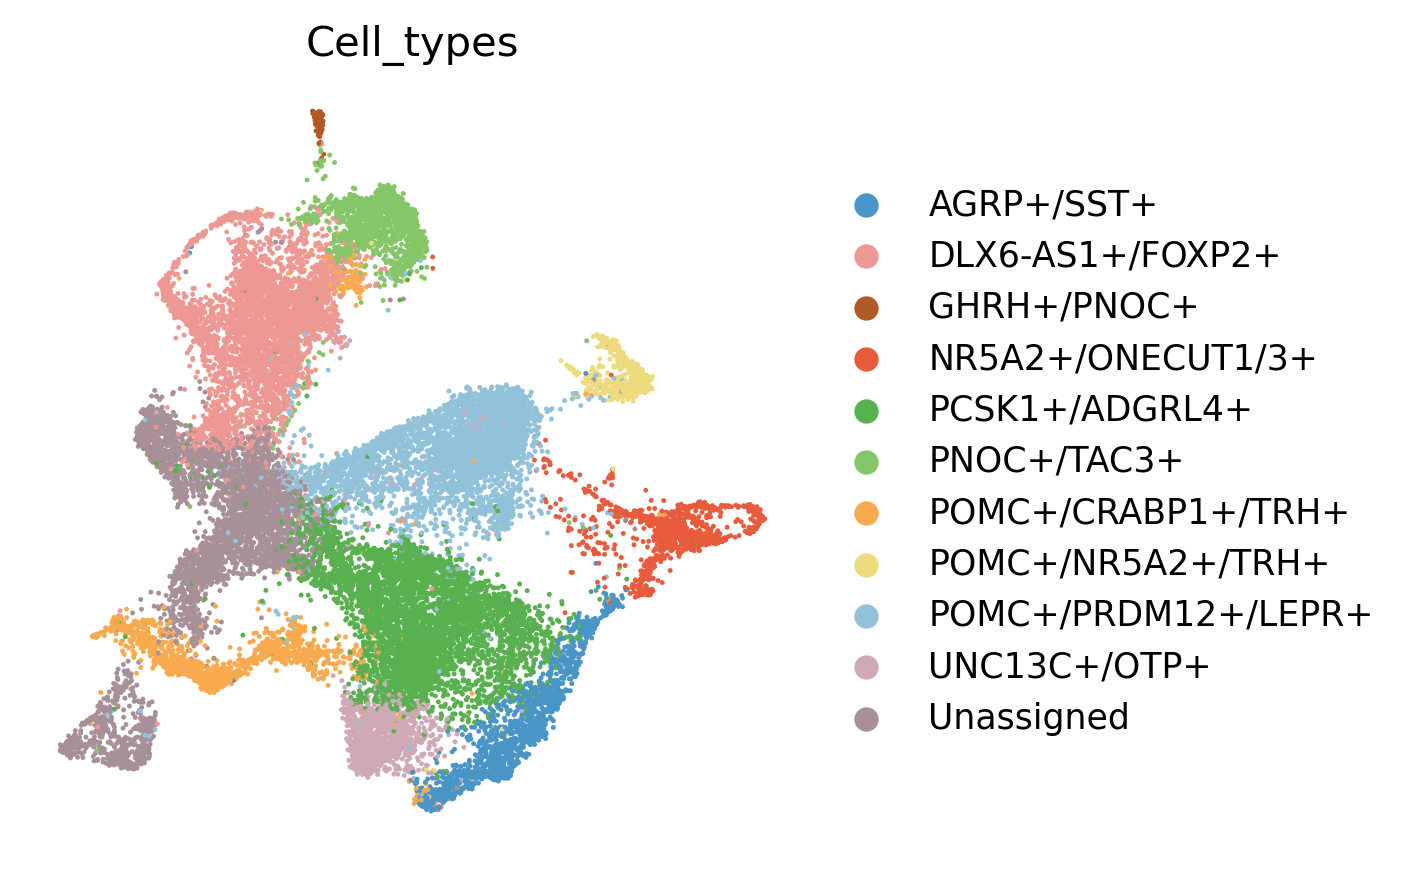

In [39]:
with plt.rc_context({ "figure.dpi": 250, "figure.figsize": (4,4)}):
    sc.pl.umap(adata_neurons, color=['Cell_types'],frameon=False, use_raw=False, size=8,
               ncols=2,cmap='jet',wspace=0.4)

[<matplotlib.patches.Rectangle object at 0x15318cde9970>, <matplotlib.patches.Rectangle object at 0x15318cde9f70>, <matplotlib.patches.Rectangle object at 0x15327cdc6a00>, <matplotlib.patches.Rectangle object at 0x15327cd885e0>, <matplotlib.patches.Rectangle object at 0x15327cd88220>, <matplotlib.patches.Rectangle object at 0x15327cd86af0>, <matplotlib.patches.Rectangle object at 0x15327cd87df0>, <matplotlib.patches.Rectangle object at 0x15327cd8bc40>, <matplotlib.patches.Rectangle object at 0x15327c94de20>, <matplotlib.patches.Rectangle object at 0x15318cdf8610>, <matplotlib.patches.Rectangle object at 0x15318cdf8be0>]


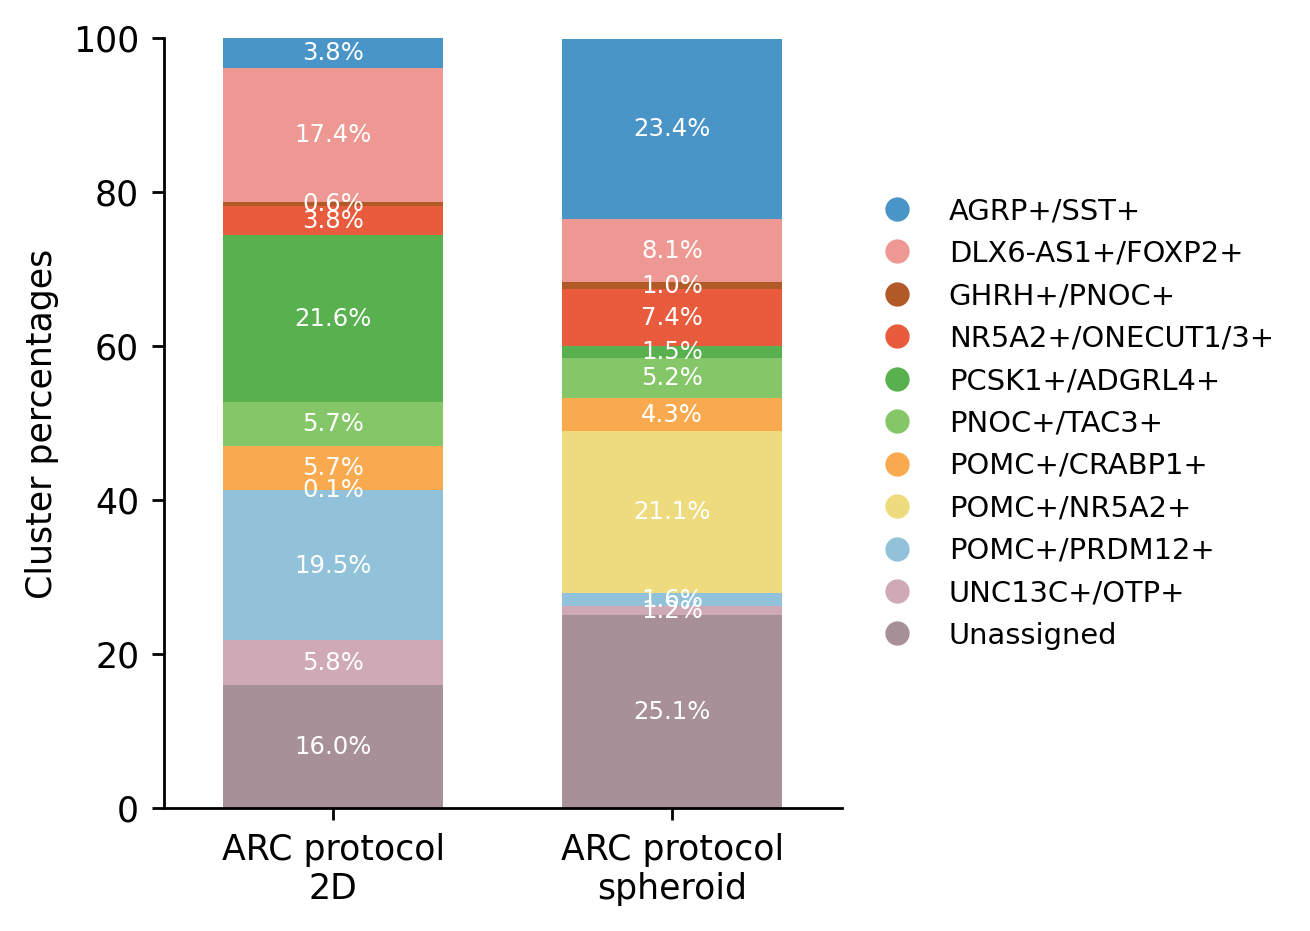

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

category_names = list(adata_neurons.obs['Cell_types'].cat.categories)

# Retrieve percentage lists for both datasets
percentages_2D = list(adata_neurons[adata_neurons.obs.dimensionality.isin(['2D'])].obs['Cell_types'].value_counts(normalize=True).mul(100).round(1).sort_index(ascending=True).values)
percentages_spheroid = list(adata_neurons[adata_neurons.obs.dimensionality.isin(['spheroid'])].obs['Cell_types'].value_counts(normalize=True).mul(100).round(1).sort_index(ascending=True).values)

# Create a dictionary with the percentage lists for each dataset
results = {
    'ARC protocol\n2D': list(adata_neurons[adata_neurons.obs.dimensionality.isin(['2D'])].obs['Cell_types'].value_counts(normalize=True).mul(100).round(1).sort_index(ascending=True).values),
    'ARC protocol\nspheroid': list(adata_neurons[adata_neurons.obs.dimensionality.isin(['spheroid'])].obs['Cell_types'].value_counts(normalize=True).mul(100).round(1).sort_index(ascending=True).values)
}



def survey_vertical(results, category_names):
    category_names = category_names[::-1]
    labels = list(results.keys())
    data = np.array(list(results.values()))[:, ::-1]  # Ensure data is numeric
    data_cum = data.cumsum(axis=1)
    category_colors = reversed(['#4a95c8', '#ed9892', '#b15a27', '#e85b3d', '#58b04e', '#85c668',
        '#faaa4e', '#eddb7e', '#91c2da', '#d0a9b7', '#a79098'])

    with plt.rc_context({ "figure.dpi": 250}):
    
        fig, ax = plt.subplots(figsize=(3.5, 4))
        ax.set_ylim(0, np.sum(data, axis=1).max())
        ax.set_xlim(-0.5, len(labels) - 0.5)

        for i, (colname, color) in enumerate(zip(category_names, category_colors)):
            heights = data[:, i]
            starts = data_cum[:, i] - heights
            rects = ax.bar(labels, heights, bottom=starts, width=0.65,
                           label=colname, color=color)

            #r, g, b, _ = color
            #text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
            percentage_labels = [f"{height}%" for height in heights]
            ax.bar_label(rects, labels=percentage_labels, label_type='center', color='white', fontsize=7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        line1 = mlines.Line2D([], [], color="white", marker='o',label='AGRP+/SST+', markersize=8, markerfacecolor='#4a95c8')
        line2 = mlines.Line2D([], [], color="white", marker='o',label='DLX6-AS1+/FOXP2+', markersize=8, markerfacecolor='#ed9892')
        line3 = mlines.Line2D([], [], color="white", marker='o',label='GHRH+/PNOC+', markersize=8,  markerfacecolor='#b15a27')
        line4 = mlines.Line2D([], [], color="white", marker='o',label='NR5A2+/ONECUT1/3+', markersize=8, markerfacecolor='#e85b3d')
        
        line5 = mlines.Line2D([], [], color="white", marker='o',label='PCSK1+/ADGRL4+', markersize=8, markerfacecolor='#58b04e')
        line6 = mlines.Line2D([], [], color="white", marker='o',label='PNOC+/TAC3+', markersize=8, markerfacecolor='#85c668')
        line7 = mlines.Line2D([], [], color="white", marker='o',label='POMC+/CRABP1+', markersize=8,  markerfacecolor='#faaa4e')
        line8 = mlines.Line2D([], [], color="white", marker='o',label='POMC+/NR5A2+', markersize=8, markerfacecolor='#eddb7e')
        
        line9 = mlines.Line2D([], [], color="white", marker='o',label='POMC+/PRDM12+', markersize=8, markerfacecolor='#91c2da')
        line10 = mlines.Line2D([], [], color="white", marker='o',label='UNC13C+/OTP+', markersize=8,  markerfacecolor='#d0a9b7')
        line11 = mlines.Line2D([], [], color="white", marker='o',label='Unassigned', markersize=8, markerfacecolor='#a79098')
        
        #p#lt.legend((line1, line2, line3, line4), ('Thing 1', 'Thing 2', 'Thing 3', 'Thing 4')
        print(ax.patches[::len(labels)])
        ax.legend(reversed(ax.patches[::len(labels)]),ncols=1,handles=[line1, line2, line3, line4,line5,line6,line7,line8,line9,line10,line11],
                  loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small',frameon=False)
        ax.set_ylabel('Cluster percentages')
    #ax.set_xlabel('Questions')
    return fig, ax

survey_vertical(results, category_names)
plt.savefig('figures/cluster_percentages_neurons.pdf', bbox_inches='tight')
plt.show()


## DEG analysis

In [ ]:
adata_neurons = sc.read('Data/adata_d50_d70_neurons.h5ad')


In [42]:
%%R -i adata_d50_d70

Csparse_validate = "CsparseMatrix_validate"
library(Seurat)
library(edgeR)

seur <- as.Seurat(adata_neurons, counts = "counts", data = NULL)

#seur <- readRDS("Data/d50_d70_neurons_seurat.rds")
seur <- RenameAssays(seur, originalexp="RNA")

y <- Seurat2PB(seur, sample = "diff_batch_2", cluster = "Cell_types")
keep.samples <- y$samples$lib.size > 5e4
y <- y[, keep.samples]
keep.genes <- filterByExpr(y, group=y$samples$cluster)
y <- y[keep.genes, , keep=FALSE]
y <- normLibSizes(y)

cluster <- as.factor(y$samples$cluster)
#plotMDS(y, pch=16, col=c(2:16)[cluster], main="MDS")
#legend("bottomright", legend=paste0("cluster",levels(cluster)), pch=16, col=2:16, cex=0.8)

Renaming default assay from originalexp to RNA
In addition: Warning message:
Cannot add objects with duplicate keys (offending key: originalexp_) setting key to original value 'rna_' 


In [43]:
%%R
batch <- factor(y$samples$sample)
design <- model.matrix(~ cluster + batch)
colnames(design) <- gsub("batch", "", colnames(design))
colnames(design)[1] <- "Int"
head(design)

  Int clusterDLX6-AS1+/FOXP2+ clusterGHRH+/PNOC+ clusterNR5A2+/ONECUT1/3+
1   1                       0                  0                        0
2   1                       1                  0                        0
3   1                       0                  1                        0
4   1                       0                  0                        1
5   1                       0                  0                        0
6   1                       0                  0                        0
  clusterPCSK1+/ADGRL4+ clusterPNOC+/TAC3+ clusterPOMC+/CRABP1+/TRH+
1                     0                  0                         0
2                     0                  0                         0
3                     0                  0                         0
4                     0                  0                         0
5                     1                  0                         0
6                     0                  1                         0

In [44]:

%%R
y <- estimateDisp(y, design, robust=TRUE)
fit <- glmQLFit(y, design, robust=TRUE)

In [45]:
%%R
ncls <- nlevels(cluster)
contr <- rbind( matrix(1/(1-ncls), ncls, ncls), matrix(0, ncol(design)-ncls, ncls) )
diag(contr) <- 1
contr[1,] <- 0
rownames(contr) <- colnames(design)
colnames(contr) <- paste0("cluster", levels(cluster))
contr

                           clusterAGRP+/SST+ clusterDLX6-AS1+/FOXP2+
Int                                      0.0                     0.0
clusterDLX6-AS1+/FOXP2+                 -0.1                     1.0
clusterGHRH+/PNOC+                      -0.1                    -0.1
clusterNR5A2+/ONECUT1/3+                -0.1                    -0.1
clusterPCSK1+/ADGRL4+                   -0.1                    -0.1
clusterPNOC+/TAC3+                      -0.1                    -0.1
clusterPOMC+/CRABP1+/TRH+               -0.1                    -0.1
clusterPOMC+/NR5A2+/TRH+                -0.1                    -0.1
clusterPOMC+/PRDM12+/LEPR+              -0.1                    -0.1
clusterUnassigned                       -0.1                    -0.1
clusterUNC13C+/OTP+                     -0.1                    -0.1
-2                                       0.0                     0.0
-3                                       0.0                     0.0
                           cluster

In [46]:
%%R
qlf <- list()
for(i in 1:ncls){
 qlf[[i]] <- glmQLFTest(fit, contrast=contr[,i])
 qlf[[i]]$comparison <- paste0("cluster", levels(cluster)[i], "_vs_others")
}

In [47]:
%%R
top <- 200
topMarkers <- list()

de_df = data.frame(matrix( 
  vector(), 0, 7, dimnames=list(c(), c("gene","logFC","logCPM","F","PValue","FDR",'comparison'))), 
                stringsAsFactors=F)

for(i in 1:ncls) {
    #print(head(qlf[[i]])$comparison)
    ord <- order(qlf[[i]]$table$PValue, decreasing=FALSE)
    up <- qlf[[i]]$table$logFC[ord] > 0
    topMarkers[[i]] <- rownames(y)[ord[up][1:top]]
    #genes = 
    df = as.data.frame(topTags(qlf[[i]], n='all'))
    df =df[rownames(df) %in% rownames(y)[ord[up][1:top]], ]  
    df$comparison <- head(qlf[[i]])$comparison
    de_df = rbind(de_df, df)
}
print(dim(de_df))

write.csv(de_df, "d50_70_arc_neurons_de_list.csv")
#topMarkers <- unique(unlist(topMarkers))
#topMarkers

[1] 2200    8


In [48]:
de_genes = pd.read_csv('d50_70_arc_neurons_de_list.csv',index_col=0)
de_genes['cluster'] = de_genes['comparison'].str.extract(r'cluster(.*?)_vs_others')
de_genes = de_genes[['gene','logFC','logCPM','F','PValue','FDR','comparison','cluster']]
de_genes.to_excel("d50_70_arc_neurons_de_list.xlsx")  
de_genes

gene     logFC    logCPM            F        PValue  \
SYDE2            SYDE2  3.423320  4.550303  1220.725324  5.310709e-29   
THSD4            THSD4  3.270518  5.002692   949.130689  5.190075e-27   
ADCYAP1        ADCYAP1  4.775833  1.595063   702.817393  6.448379e-25   
PTPRK            PTPRK  2.337129  7.568537   705.095966  3.862999e-24   
CPA4              CPA4  2.734215  5.183489   590.180865  4.074366e-23   
...                ...       ...       ...          ...           ...   
LINC004611   LINC00461  1.195963  3.175053    36.697530  7.801162e-07   
AP005131.3  AP005131.3  1.019423  2.257673    35.788963  7.851396e-07   
RIPOR2          RIPOR2  0.723758  4.653800    35.762686  7.904134e-07   
ZNF462          ZNF462  0.600675  6.730747    35.676566  8.079627e-07   
SPINK5          SPINK5  0.670157  5.091559    35.661551  8.110643e-07   

                     FDR                     comparison       cluster  
SYDE2       1.238192e-24    clusterAGRP+/SST+_vs_others    AGRP+/SST+  
THSD4       6.050330e-23    clusterAGRP+/SST+_vs_others    AGRP+/SST+  
ADCYAP1     5.011465e-21    clusterAGRP+/SST+_vs_others    AGRP+/SST+  
PTPRK       2.251646e-20    clusterAGRP+/SST+_vs_others    AGRP+/SST+  
CPA4        1.699896e-19    clusterAGRP+/SST+_vs_others    AGRP+/SST+  
...                  ...                            ...           ...  
LINC004611  6.315419e-05  clusterUNC13C+/OTP+_vs_others  UNC13C+/OTP+  
AP005131.3  6.316638e-05  clusterUNC13C+/OTP+_vs_others  UNC13C+/OTP+  
RIPOR2      6.332814e-05  clusterUNC13C+/OTP+_vs_others  UNC13C+/OTP+  
ZNF462      6.451250e-05  clusterUNC13C+/OTP+_vs_others  UNC13C+/OTP+  
SPINK5      6.453912e-05  clusterUNC13C+/OTP+_vs_others  UNC13C+/OTP+  

[2200 rows x 8 columns]

In [51]:
de_dict = {}
for cluster in list(de_genes.cluster.unique()):
    de_dict[str(cluster)] = list(de_genes.groupby('cluster').get_group(cluster).gene)[0:6]
#de_dict
de_genes['cluster'].value_counts()

cluster
AGRP+/SST+             200
DLX6-AS1+/FOXP2+       200
GHRH+/PNOC+            200
NR5A2+/ONECUT1/3+      200
PCSK1+/ADGRL4+         200
PNOC+/TAC3+            200
POMC+/CRABP1+/TRH+     200
POMC+/NR5A2+/TRH+      200
POMC+/PRDM12+/LEPR+    200
Unassigned             200
UNC13C+/OTP+           200
Name: count, dtype: int64

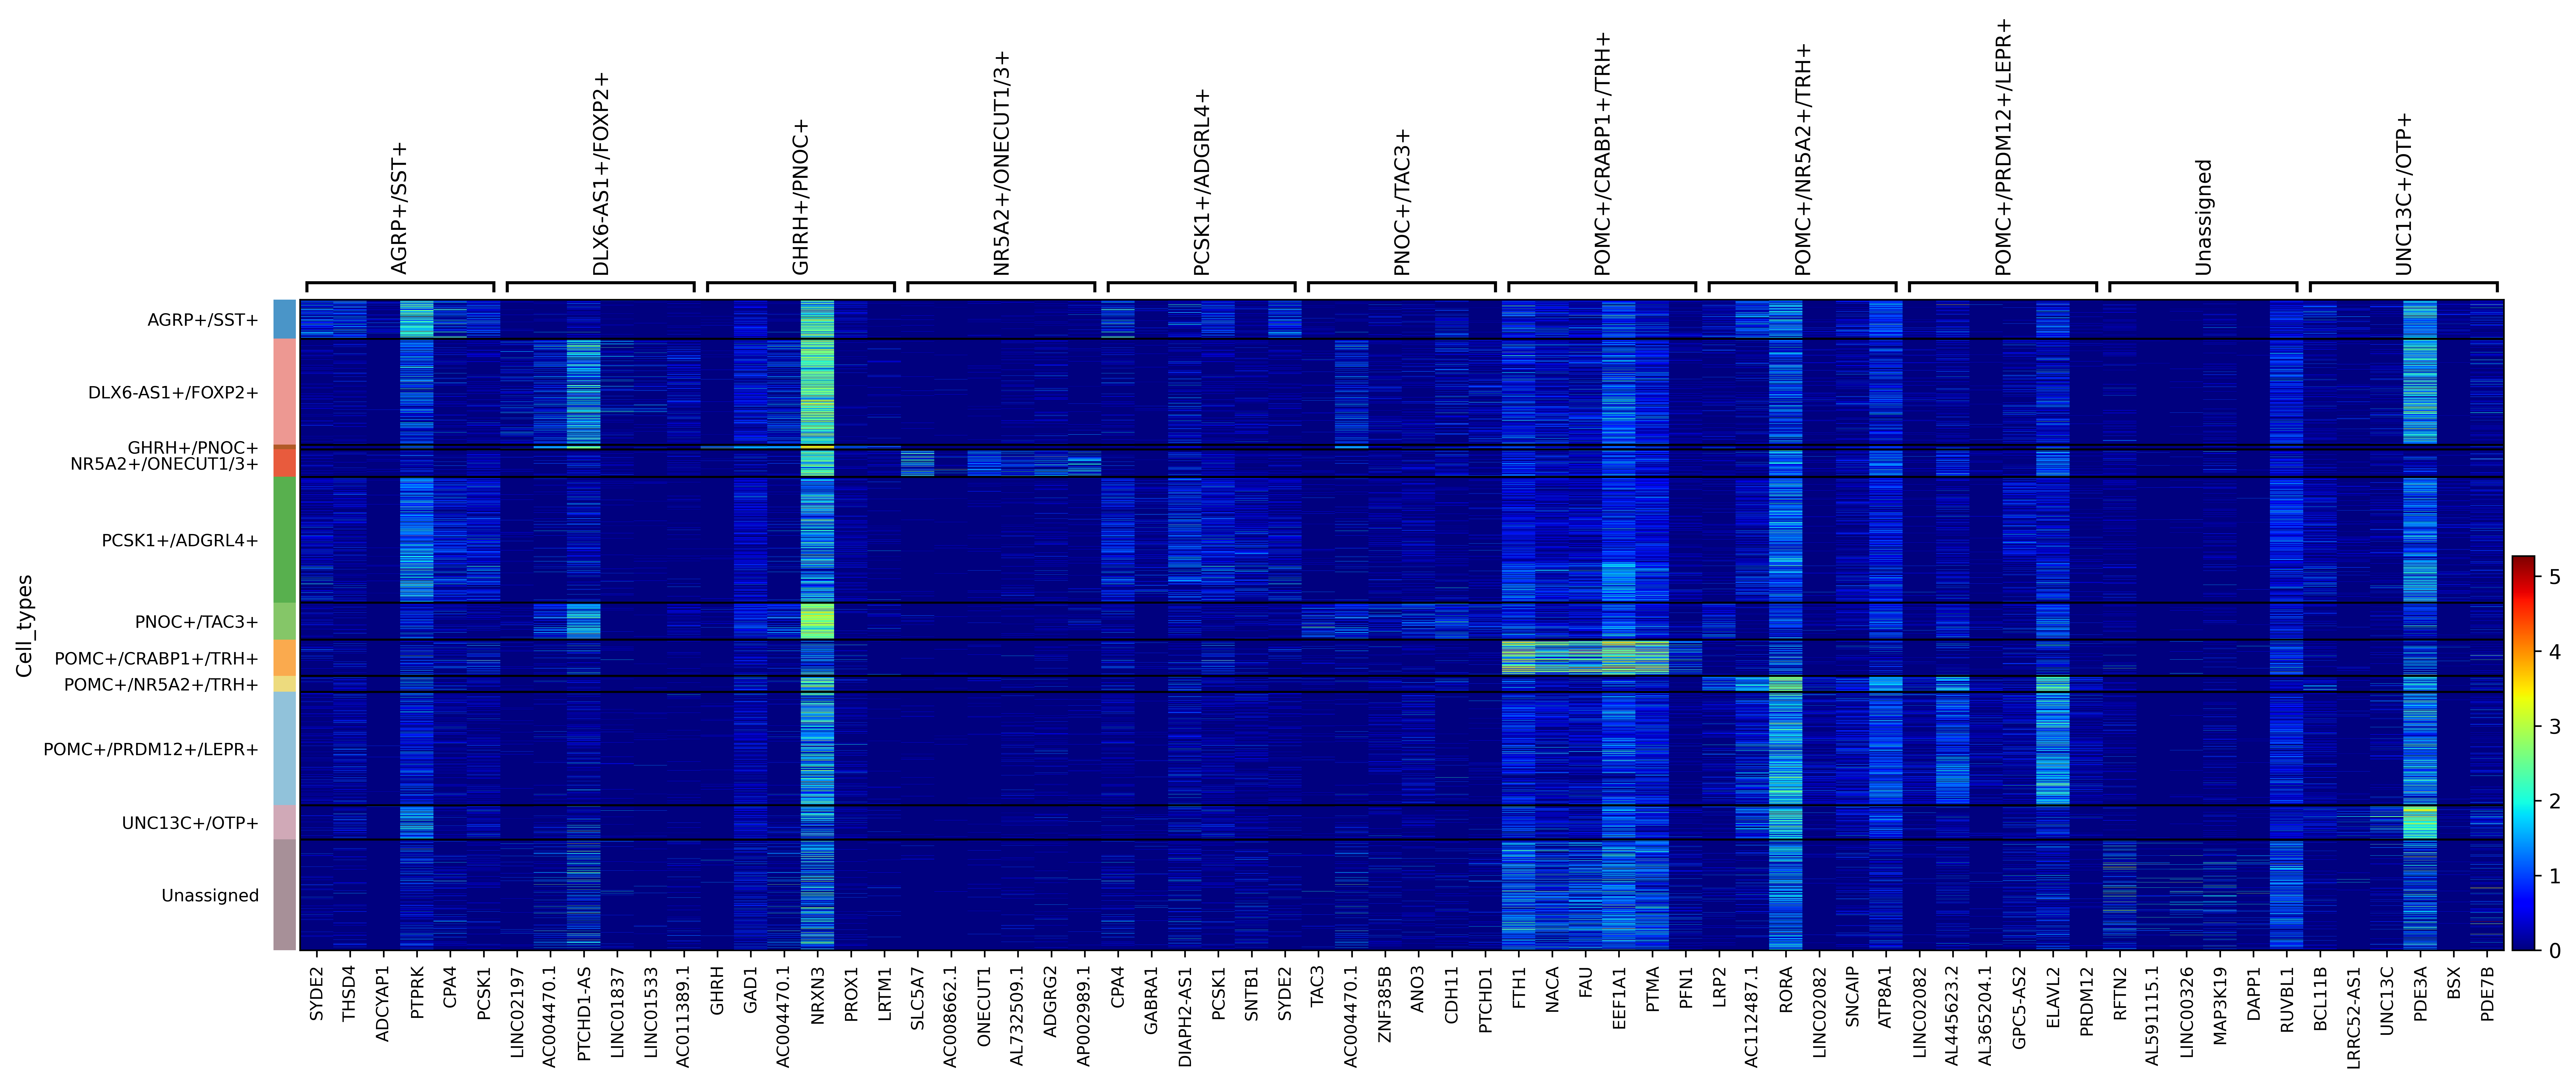

In [52]:
with plt.rc_context({ "figure.dpi": 600, "figure.figsize": (100,10)}):
    sc.pl.heatmap(adata_neurons,de_dict, groupby='Cell_types', show_gene_labels=True, layer='log_transformed',cmap='jet')